In [25]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import pytesseract
from pathlib import Path
import pandas as pd
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

In [3]:
torch.cuda.is_available()

True

In [4]:
import kagglehub
#dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
dataset_path = kagglehub.dataset_download("chiragsaipanuganti/morph")

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 303M/303M [00:35<00:00, 8.99MB/s] 

Extracting files...


In [6]:
dataset_path

'/root/.cache/kagglehub/datasets/chiragsaipanuganti/morph/versions/2'

In [5]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_paths.append(os.path.join(root, file))

In [ ]:
def populate_whitecard(image_paths, naming, height=1540, width=1754, im_width=250, im_height=250, spacing=80):
    whitecard = np.ones((height, width, 3), dtype=np.uint8) * 255
    x = 10
    y = 10

    diagonal_size = int(np.sqrt(im_width**2 + im_height**2)) + 10

    for i, name in zip(image_paths, naming):
        img = cv2.imread(i)
        img = cv2.resize(img, (im_width, im_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rot_canvas = np.ones((diagonal_size, diagonal_size, 3), dtype=np.uint8) * 255
        start_x = (diagonal_size - im_width) // 2
        start_y = (diagonal_size - im_height) // 2
        rot_canvas[start_y:start_y + im_height, start_x:start_x + im_width] = img

        rot_angle = random.uniform(-180, 180)
        center = (diagonal_size // 2, diagonal_size // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
        rot_img = cv2.warpAffine(rot_canvas, rot_matrix, (diagonal_size, diagonal_size), borderValue=(255, 255, 255))

        whitecard[y:y+diagonal_size, x:x+diagonal_size] = rot_img

        cv2.putText(whitecard, str(name), (x + diagonal_size // 2, y + diagonal_size + (spacing // 2)), 
                   cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1.3, (0, 0, 0), 2, cv2.LINE_AA)

        x += diagonal_size + 40
        if x > (width-diagonal_size):
            x = 10
            y += diagonal_size + spacing
        if y > (height-diagonal_size):
            return whitecard
    return whitecard

def get_cards(image_paths, num, im_width, im_height):
    cards = []
    random.shuffle(image_paths)
    for i in range(num):
        card = populate_whitecard(image_paths[i*20:(i+1)*20], [f"{i*20+j+1}" for j in range(20)], im_height=im_height, im_width=im_width)
        cards.append(card)
    return cards

In [70]:
def populate_whitecard_labels(image_paths, naming, height=1540, width=1754, im_width=250, im_height=250, spacing=80):
    whitecard = np.ones((height, width, 3), dtype=np.uint8) * 255
    x = 10
    y = 10

    diagonal_size = int(np.sqrt(im_width**2 + im_height**2)) + 10
    label_entries = []

    for i, name in zip(image_paths, naming):
        img = cv2.imread(i)
        img = cv2.resize(img, (im_width, im_height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        rot_canvas = np.ones((diagonal_size, diagonal_size, 3), dtype=np.uint8) * 255
        start_x = (diagonal_size - im_width) // 2
        start_y = (diagonal_size - im_height) // 2
        rot_canvas[start_y:start_y + im_height, start_x:start_x + im_width] = img

        rot_angle = random.uniform(-180, 180)
        center = (diagonal_size // 2, diagonal_size // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, rot_angle, 1.0)
        rot_img = cv2.warpAffine(rot_canvas, rot_matrix, (diagonal_size, diagonal_size), borderValue=(255, 255, 255))

        whitecard[y:y+diagonal_size, x:x+diagonal_size] = rot_img

        cv2.putText(whitecard, str(name), (x + diagonal_size // 2, y + diagonal_size + (spacing // 2)), 
                   cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1.3, (0, 0, 0), 2, cv2.LINE_AA)
        
        box_x_center = (x + diagonal_size / 2) / width
        box_y_center = (y + diagonal_size / 2 + spacing / 2) / height
        box_width = diagonal_size / width
        box_height = (diagonal_size + spacing) / height
        label_entries.append(f"0 {box_x_center:.6f} {box_y_center:.6f} {box_width:.6f} {box_height:.6f}")

        x += diagonal_size + 40
        if x > (width-diagonal_size):
            x = 10
            y += diagonal_size + spacing
        if y > (height-diagonal_size):
            break
    return whitecard, label_entries

def get_cards_labels(image_paths, num, im_width, im_height, output_path):
    output_path = Path(output_path)
    output_path.mkdir(exist_ok=True)
    labels_path = output_path / "labels"
    labels_path.mkdir(exist_ok=True)
    cards = []

    random.shuffle(image_paths)
    for i in range(num):
        imgs = image_paths[i*20:(i+1)*20]
        names = [f"{i*20+j+1}" for j in range(len(imgs))]
        card, labels = populate_whitecard_labels(imgs, names, im_width=im_width, im_height=im_height)
        filename = f"card_{i+1}"
        
        card_bgr = cv2.cvtColor(card, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(output_path / f"{filename}.jpg"), card_bgr)

        with open(labels_path / f"{filename}.txt", "w") as f:
            f.write("\n".join(labels))
    return cards

In [72]:
get_cards_labels(image_paths, num=100, im_width=200, im_height=200, output_path="validation_cards")

[]

In [11]:
model = YOLO('yolo11n.pt')  # nano
model = YOLO('yolo11s.pt')  # small
model = YOLO('yolo11m.pt')  # medium
model = YOLO('yolo11l.pt')  # large
model = YOLO('yolo11x.pt')  # extra large

In [12]:
model = YOLO('yolo11n-pose.pt')  # nano
model = YOLO('yolo11s-pose.pt')  # small
model = YOLO('yolo11m-pose.pt')  # medium
model = YOLO('yolo11l-pose.pt')  # large
model = YOLO('yolo11x-pose.pt')  # extra large

In [81]:
from ultralytics import YOLO

model = YOLO('yolo11x.pt')

model.train(
    data='person_entry.yaml',
    epochs=100,
    imgsz=1024,
    batch=8,
    name='person_entry_model'
)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.144 🚀 Python-3.11.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=person_entry.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_entry_model3, nbs=64, nms=False

train: Scanning /repos/uni-si/R2S4/DNN/End_project/labels/train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1126.68it/s]

train: New cache created: /repos/uni-si/R2S4/DNN/End_project/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2731.9±2230.4 MB/s, size: 415.8 KB)


val: Scanning /repos/uni-si/R2S4/DNN/End_project/labels/test... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 953.87it/s]

val: New cache created: /repos/uni-si/R2S4/DNN/End_project/labels/test.cache


Plotting labels to runs/detect/person_entry_model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/person_entry_model3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      37.8G       1.95      1.912       2.46         85       1024: 100%|██████████| 13/13 [01:39<00:00,  7.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]

                   all        100       2000      0.983      0.992      0.995       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      37.4G      0.926     0.7484      1.307        154       1024: 100%|██████████| 13/13 [02:12<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:11<00:00, 10.20s/it]

                   all        100       2000          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      37.3G     0.9348     0.7083      1.354        214       1024: 100%|██████████| 13/13 [02:09<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:12<00:31,  6.32s/it]


KeyboardInterrupt: 

In [79]:
import os

img_dir = "validation_cards"
label_dir = os.path.join(img_dir, "labels")

imgs = sorted([f.strip() for f in os.listdir(img_dir) if f.lower().endswith(".jpg")])
labels = sorted([f.strip() for f in os.listdir(label_dir) if f.lower().endswith(".txt")])

print("Liczba obrazów:", len(imgs))
print("Liczba labeli:", len(labels))

img_base = [os.path.splitext(f)[0].lower() for f in imgs]
label_base = [os.path.splitext(f)[0].lower() for f in labels]

set_img = set(img_base)
set_label = set(label_base)

print("Obrazy bez labeli:", set_img - set_label)
print("Labeli bez obrazów:", set_label - set_img)


Liczba obrazów: 100
Liczba labeli: 100
Obrazy bez labeli: set()
Labeli bez obrazów: set()


In [64]:
class CardProcessor:
    def __init__(self, detection_model="yolo11x.pt", pose_model="yolo11x-pose.pt"):
        self.detection_model = YOLO(detection_model)
        self.pose_model = YOLO(pose_model)

        self.debug_ocr_path = Path("debug_ocr_images")
        self.debug_ocr_path.mkdir(exist_ok=True)
        self.ocr_debug_counter = 0

        try:
            self.trocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-stage1', use_fast=True)
            self.trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-stage1')
            if torch.cuda.is_available() and self.trocr_model is not None:
                self.trocr_model.to('cuda')
            print("TrOCR model loaded successfully.")
        except Exception as e:
            print(f"Error loading TrOCR model: {e}. TrOCR will not be available.")
            self.trocr_processor = None
            self.trocr_model = None
    
    def process_card(self, card_path):
        card = cv2.imread(card_path)

        image_regions = self.detect_image_regions(card)

        print(f"Found {len(image_regions)} image regions.")

        results = []
        valid_count = 0
        for i, region in enumerate(image_regions):
            crop = self.extract_crop(card, region)
            if crop.shape[0] < 50 or crop.shape[1] < 50:
                continue
        
            rotated_crop, angle = self.correct_orientation(crop)
        
            is_valid = self.validate_photo(rotated_crop)

            if is_valid:
                valid_count += 1
                id = self.find_id(card, region)

                results.append({
                    'id': id,
                    'rotated_crop': rotated_crop,
                    'angle': angle,
                    'source_card': Path(card_path).name,
                    'region_idx': i,
                    'region': region
                })
        print(f"Valid faces found: {valid_count}/{len(image_regions)}")
        return results
    
    def detect_image_regions(self, card):
        # This method will now primarily use YOLO to detect image content.
        # Padding will be added to YOLO detections to make them less tightly cropped.
        
        yolo_detected_content_regions = []
        yolo_results = self.detection_model(card, classes=[0], verbose=False) # classes=[0] for person/face
        
        # Define padding percentage (e.g., 15% added to each side, so total increase is 30% of original)
        # Or, simpler: increase width and height by a factor. Let's try increasing w and h by 20%.
        padding_factor_w = 1.20 # Increase width by 20%
        padding_factor_h = 1.20 # Increase height by 20%

        card_h_for_bounds, card_w_for_bounds = card.shape[:2]

        for result in yolo_results:
            if result.boxes is not None:
                for box in result.boxes:
                    if box.conf[0] > 0.3: 
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                        
                        orig_x, orig_y = int(x1), int(y1)
                        orig_w, orig_h = int(x2 - x1), int(y2 - y1)

                        if orig_w <= 0 or orig_h <= 0: # Skip invalid original detections
                            continue

                        # Calculate new dimensions with padding
                        padded_w = int(orig_w * padding_factor_w)
                        padded_h = int(orig_h * padding_factor_h)

                        # Calculate new top-left coordinates, keeping the center
                        # delta_w = padded_w - orig_w
                        # delta_h = padded_h - orig_h
                        # new_x = orig_x - delta_w // 2
                        # new_y = orig_y - delta_h // 2
                        
                        # Simpler: calculate center, then new x1,y1 from new w,h
                        center_x = orig_x + orig_w / 2
                        center_y = orig_y + orig_h / 2

                        new_x = int(round(center_x - padded_w / 2))
                        new_y = int(round(center_y - padded_h / 2))
                        
                        # Ensure padded region is within card boundaries
                        final_x = max(0, new_x)
                        final_y = max(0, new_y)
                        final_w = min(padded_w, card_w_for_bounds - final_x)
                        final_h = min(padded_h, card_h_for_bounds - final_y)

                        if final_w > 0 and final_h > 0: 
                            yolo_detected_content_regions.append((final_x, final_y, final_w, final_h))
                            
        print(f"YOLO detected and padded {len(yolo_detected_content_regions)} raw content regions.")

        # Deduplicate regions detected by YOLO
        unique_yolo_regions = self.remove_duplicate_regions(yolo_detected_content_regions, iou_threshold=0.4) 
        print(f"Unique content regions after YOLO deduplication: {len(unique_yolo_regions)}")
        
        # Filter these content regions using your existing filter_valid_regions method
        # The filter_valid_regions parameters (min_expected_content_dimension = 180, 
        # max_expected_content_dimension = 330) should be appropriate for these padded regions.
        # Original content ~200-283. Padded by 1.2 factor -> ~240-340. This range is mostly
        # covered by [180,330], though the upper bound might clip some slightly.
        # If issues persist, max_expected_content_dimension might need a slight increase.
        valid_content_regions = self.filter_valid_regions(unique_yolo_regions, card.shape)
        print(f"Valid content regions after filtering: {len(valid_content_regions)}")

        final_regions_sorted = sorted(valid_content_regions, key=lambda r: (r[1], r[0]))
        
        return final_regions_sorted
    
    def remove_duplicate_regions(self, regions, iou_threshold=0.4):
        if not regions:
            return []
        
        regions_list = list(regions)
        unique_regions = []

        while regions_list:
            current_region = regions_list.pop(0) 
            unique_regions.append(current_region)

            remaining_regions_after_check = []
            for region_to_compare in regions_list:
                iou = self.calculate_iou(current_region, region_to_compare)
                if iou <= iou_threshold: 
                    remaining_regions_after_check.append(region_to_compare)

            regions_list = remaining_regions_after_check 
            
        return unique_regions
    
    def calculate_iou(self, region1, region2):
        x1, y1, w1, h1 = region1
        x2, y2, w2, h2 = region2

        x_intersect = max(x1, x2)
        y_intersect = max(y1, y2)
        w_intersect = min(x1 + w1, x2 + w2)
        h_intersect = min(y1 + h1, y2 + h2)

        if w_intersect <= x_intersect or h_intersect <= y_intersect:
            return 0
        
        intersection = (w_intersect - x_intersect) * (h_intersect - y_intersect)

        area1 = w1 * h1
        area2 = w2 * h2

        if area1 == 0 or area2 == 0:
            return 0
        
        iou = intersection / float(area1 + area2 - intersection)

        return iou
    
    def filter_valid_regions(self, regions, card_shape):
        valid_regions = []
        card_h, card_w = card_shape[:2]
        min_size = 100
        max_size = min(card_h, card_w) // 3

        for x, y, w, h in regions:
            aspect_ratio = max(w, h) / min(w, h) if min(w,h) > 0 else 0 
            if aspect_ratio > 1.5:
                continue
            if min_size <= min(w, h) and max(w, h) <= max_size:
                margin = 5
                if (margin < x < card_w - w - margin and
                    margin < y < card_h - h - margin):
                    valid_regions.append((x, y, w, h))

        return valid_regions
    
    def find_id(self, card, region):
        x, y, w, h = region

        search_areas = []

        below_y = y + h
        below_h = min(80, card.shape[0] - below_y)
        search_x = max(0, x + 10)
        search_w = min(card.shape[1] - search_x, w + 40)

        if below_y + below_h <= card.shape[0] and search_x + search_w <= card.shape[1] and below_h > 0 and search_w > 0:
            search_areas.append(('below', (search_x, below_y, search_w, below_h)))
        
        #above_h = min(60, y)
        #if above_h > 10:
        #    search_areas.append(('above', (x, max(0, y - above_h), w, above_h)))

        #right_x = x + w + 2
        #right_w = min(100, card.shape[1] - right_x)
        #if right_x + right_w <= card.shape[1]:
        #    search_areas.append(('right', (right_x, y, right_w, h)))
        
        #left_w = min(100, x)
        #if left_w > 10:
        #    search_areas.append(('left', (max(0, x - left_w), y, left_w, h)))

        for location, (sx, sy, sw, sh) in search_areas:
            id = self.extract_id(card, (sx, sy, sw, sh))

            if id not in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                return id
            
        return "ID_NOT_DETECTED"
    
    def extract_id(self, card, region):
        if self.trocr_model is None or self.trocr_processor is None:
            print("Debug - TrOCR model not initialized, skipping OCR.")
            return "OCR_ERROR"
        
        x, y, w, h = region

        x = max(0, x)
        y = max(0, y)
        w = min(w, card.shape[1] - x)
        h = min(h, card.shape[0] - y)

        if w <= 0 or h <= 0:
            print(f"Debug - Invalid crop dimensions for OCR: w={w}, h={h}")
            return "ID_NOT_FOUND"
        
        id_crop = card[y:y+h, x:x+w]

        if id_crop.size == 0:
            print(f"Debug - Empty crop for OCR for region {region}")
            return "ID_NOT_FOUND"
        
        min_crop_dim_for_ocr = 10
        if id_crop.shape[0] < min_crop_dim_for_ocr or id_crop.shape[1] < min_crop_dim_for_ocr:
            print(f"Debug - OCR crop too small: {id_crop.shape}")
            return "ID_NOT_DETECTED"
        
        ocr_attempt_filename_prefix = f"ocr_input_{self.ocr_debug_counter}"
        self.ocr_debug_counter += 1

        try:
            pil_image = Image.fromarray(cv2.cvtColor(id_crop, cv2.COLOR_BGR2RGB))
            
            pixel_values = self.trocr_processor(images=pil_image, return_tensors="pt").pixel_values
            if torch.cuda.is_available():
                 pixel_values = pixel_values.to(self.trocr_model.device)

            generated_ids = self.trocr_model.generate(pixel_values, max_length=10) 

            decoded_texts = self.trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)

            if not decoded_texts or not decoded_texts[0].strip():
                debug_filename = self.debug_ocr_path / f"{ocr_attempt_filename_prefix}_fails_empty.png"
                cv2.imwrite(str(debug_filename), id_crop)
                print(f"Debug - Saved empty/whitespace OCR crop to {debug_filename}")
                return "ID_NOT_DETECTED"

            id_text_from_ocr = decoded_texts[0].strip()

            numeric_id_text = "".join(filter(str.isdigit, id_text_from_ocr))

            if not numeric_id_text:
                debug_filename = self.debug_ocr_path / f"{ocr_attempt_filename_prefix}_fails_nonumeric_{id_text_from_ocr.replace(' ','_')}.png"
                cv2.imwrite(str(debug_filename), id_crop)
                print(f"Debug - Saved non-numeric OCR crop to {debug_filename} (Raw: '{id_text_from_ocr}')")
                return "ID_NOT_DETECTED"
            
            print(f"Debug - TrOCR extracted ID: {numeric_id_text} from region {region}")
            return numeric_id_text

        except Exception as e:
            print(f"Debug - Exception during TrOCR processing in extract_id for region {region}: {e}")
            return "OCR_ERROR"
        
    def correct_orientation(self, crop):
        best_crop = crop.copy()
        best_angle = 0
        best_score = 0

        angles = list(range(0, 360, 15))

        for angle in angles:
            if angle == 0:
                rotated = crop
            else:
                rotated = self.rotate_image(crop, angle)

            orientation_data = self.analyze_face_orientation(rotated)

            if orientation_data['has_face']:
                score = self.calculate_orientation_score(orientation_data)
                if score > best_score:
                    best_score = score
                    best_crop = rotated.copy()
                    best_angle = angle

        if best_angle > 0:
            angles = list(range(max(0, best_angle - 10), min(360, best_angle + 11), 1))

            for angle in angles:
                rotated = self.rotate_image(crop, angle)
                orientation_data = self.analyze_face_orientation(rotated)

                if orientation_data['has_face']:
                    score = self.calculate_orientation_score(orientation_data)
                    if score > best_score:
                        best_score = score
                        best_crop = rotated.copy()
                        best_angle = angle

        return best_crop, best_angle

    def analyze_face_orientation(self, image):

        try:
            results = self.pose_model(image, verbose=False)

            orientation_data = {
                'has_face': False,
                'confidence': 0,
                'face_upright': False,
                'keypoints': {},
            }

            for result in results:
                keypoints = result.keypoints
                boxes = result.boxes

                if keypoints is not None and boxes is not None and len(boxes) > 0:
                    if boxes.conf.is_cuda:
                        best_idx = torch.argmax(boxes.conf).item()
                    else:
                        best_idx = np.argmax(boxes.conf.cpu().numpy()).item()

                    kp = keypoints[best_idx].cpu()
                    box_conf = boxes.conf[best_idx].cpu().item()

                    nose_tensor = kp.xy[0][0]
                    left_eye_tensor = kp.xy[0][1]
                    right_eye_tensor = kp.xy[0][2]

                    nose = nose_tensor.tolist() if torch.is_tensor(nose_tensor) and nose_tensor.numel() == 2 else [0,0]
                    left_eye = left_eye_tensor.tolist() if torch.is_tensor(left_eye_tensor) and left_eye_tensor.numel() == 2 else [0,0]
                    right_eye = right_eye_tensor.tolist() if torch.is_tensor(right_eye_tensor) and right_eye_tensor.numel() == 2 else [0,0]

                    valid_keypoints = 0
                    if nose[0] > 0 and nose[1] > 0:
                        orientation_data['keypoints']['nose'] = nose
                        valid_keypoints += 1

                    if left_eye[0] > 0 and left_eye[1] > 0:
                        orientation_data['keypoints']['left_eye'] = left_eye
                        valid_keypoints += 1

                    if right_eye[0] > 0 and right_eye[1] > 0:
                        orientation_data['keypoints']['right_eye'] = right_eye
                        valid_keypoints +=1

                    if valid_keypoints >= 2:
                        orientation_data['has_face'] = True
                        orientation_data['confidence'] = box_conf

                        if 'nose' in orientation_data['keypoints'] and ('left_eye' in orientation_data['keypoints'] or 'right_eye' in orientation_data['keypoints']):
                            nose_y = orientation_data['keypoints']['nose'][1]
                            
                            if 'left_eye' in orientation_data['keypoints'] and 'right_eye' in orientation_data['keypoints']:
                                avg_eye_y = (orientation_data['keypoints']['left_eye'][1] + orientation_data['keypoints']['right_eye'][1]) / 2
                                orientation_data['face_upright'] = avg_eye_y < nose_y
                            elif 'left_eye' in orientation_data['keypoints']:
                                orientation_data['face_upright'] = orientation_data['keypoints']['left_eye'][1] < nose_y
                            elif 'right_eye' in orientation_data['keypoints']:
                                orientation_data['face_upright'] = orientation_data['keypoints']['right_eye'][1] < nose_y
                            else:
                                orientation_data['face_upright'] = False
                        else:
                            orientation_data['face_upright'] = False
                        break
            return orientation_data
        
        except Exception as e:
            return {'has_face': False, 'confidence': 0, 'face_upright': False, 'keypoints': {}}
        
    def calculate_orientation_score(self, orientation_data):
        if not orientation_data['has_face']:
            return 0
        
        score = orientation_data['confidence'] * 100

        if orientation_data['face_upright']:
            score += 50

        keypoint_count = len(orientation_data['keypoints'])
        score += keypoint_count * 5

        return score
    
    def rotate_image(self, image, angle):
        h, w = image.shape[:2]
        center = (w // 2, h // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        cos_val = abs(rotation_matrix[0, 0])
        sin_val = abs(rotation_matrix[0, 1])
        new_w = int((h * sin_val) + (w * cos_val))
        new_h = int((h * cos_val) + (w * sin_val))

        rotation_matrix[0, 2] += (new_w / 2) - center[0]
        rotation_matrix[1, 2] += (new_h / 2) - center[1]

        rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

        return rotated
    
    def extract_crop(self, card, region):
        x, y, w, h = region
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(card.shape[1] - x, w + 2 * padding)
        h = min(card.shape[0] - y, h + 2 * padding)

        crop = card[y:y+h, x:x+w]
        return crop
    
    def validate_photo(self, crop):
        try:
            results = self.detection_model(crop, classes=[0], verbose=False)

            for result in results:
                if result.boxes is not None and len(result.boxes) > 0:
                    max_conf = 0
                    if result.boxes.conf is not None and len(result.boxes.conf) > 0:
                         max_conf = result.boxes.conf.max().item()
                    
                    return max_conf > 0.05
                
            return False
        except:
            return False
        

def process_cards(input_dir, output_dir):
    processor = CardProcessor()

    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    all_images_info = []

    for image_file in input_path.glob('*.jpg'):
        print(f"Processing {image_file.name}...")
        results = processor.process_card(str(image_file))

        for result in results:
            id = result['id']
            if id in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                filename = f"unknown_{result['source_card']}_{result['region_idx']}.jpg"
            else:
                filename = f"{id}.jpg"

            output_file = output_path / filename

            counter = 1
            while output_file.exists():
                if id in ["ID_NOT_FOUND", "ID_NOT_DETECTED", "OCR_ERROR"]:
                    filename = f"unknown_{result['source_card']}_{result['region_idx']}_{counter}.jpg"
                else:
                    filename = f"{id}_{counter}.jpg"
                output_file = output_path / filename
                counter += 1
            
            cv2.imwrite(str(output_file), result['rotated_crop'])

            all_images_info.append({
                'id': result['id'],
                'filename': filename,
                'source_card': result['source_card'],
                'region_idx': result['region_idx'],
                'angle': result['angle'],
                'region_x': result['region'][0],
                'region_y': result['region'][1],
                'region_w': result['region'][2],
                'region_h': result['region'][3],
            })

            print(f"  Saved: {filename} (ID: {result['id']}, rotated: {result['angle']}°)")

    if all_images_info:
        df = pd.DataFrame(all_images_info)
        df.to_csv(output_path / 'images_info.csv', index=False)

        print(f"\nProcessing complete!")
        print(f"Total images saved: {len(all_images_info)}")
        print(f"All images saved to: {output_path}")
        print(f"Image info saved to: {output_path / 'all_images.csv'}")

    return all_images_info

In [65]:
results = process_cards('cards', 'extracted')

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_

TrOCR model loaded successfully.
Processing card_2.jpg...
YOLO detected and padded 20 raw content regions.
Unique content regions after YOLO deduplication: 20
Valid content regions after filtering: 20
Found 20 image regions.
Debug - TrOCR extracted ID: 21 from region (38, 318, 302, 80)
Debug - Saved non-numeric OCR crop to debug_ocr_images/ocr_input_1_fails_nonumeric_......png (Raw: '.....')
Debug - TrOCR extracted ID: 22 from region (386, 279, 274, 80)
Debug - TrOCR extracted ID: 23 from region (702, 276, 282, 80)
Debug - TrOCR extracted ID: 25 from region (1366, 270, 298, 80)
Debug - TrOCR extracted ID: 30 from region (1365, 686, 304, 80)
Debug - Saved non-numeric OCR crop to debug_ocr_images/ocr_input_6_fails_nonumeric_-.png (Raw: '-')
Debug - TrOCR extracted ID: 27 from region (374, 640, 286, 80)


KeyboardInterrupt: 

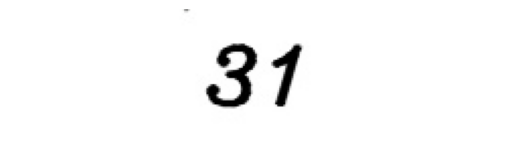

In [ ]:
img = cv2.imread('cards/card_2.jpg')
#Check region (30, 1012, 245, 120)
x, y, w, h = 60, 1040, 245, 65
crop = img[y:y+h, x:x+w]
plt.imshow(crop)
plt.axis('off')
plt.show()